In [30]:
%reset -f

In [31]:
%tensorflow_version 2.x

In [32]:
# Cargar librerias

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os
from random import randrange, uniform

In [34]:
# Borrar copia del repositorio
try:
  import shutil
  shutil.rmtree('/content/Pix2Pix_AXA')
except:
  None

In [35]:
# Install git lfs first so we can get download model checkpoints
#!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
#!apt-get install git-lfs
#!git lfs install

In [36]:
!git clone https://github.com/aldofranco91/Pix2Pix_AXA /content/Pix2Pix_AXA

Cloning into '/content/Pix2Pix_AXA'...
remote: Enumerating objects: 965, done.
remote: Counting objects: 100% (965/965), done.
remote: Compressing objects: 100% (950/950), done.
remote: Total 965 (delta 53), reused 876 (delta 12), pack-reused 0
Receiving objects: 100% (965/965), 80.32 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [37]:
def apply_damage(image):

    img = cv2.imread(image)

    for i in range(0,randrange(10,20)):
      x1, y1 = randrange(0,255), randrange(0,255)
      x2, y2 = randrange(0,255), randrange(0,255)
      color_linea = (randrange(0,255),randrange(0,255),randrange(0,255))
      line_thickness = randrange(1,5)
      img = cv2.line(img, (x1, y1), (x2, y2), color_linea, thickness=line_thickness)
    
    return img

In [38]:
# Ruta raíz
PATH = "/content/Pix2Pix_AXA"

# Ruta datos de entrada
INPATH = PATH + '/input'

# Ruta datos de salida
OUPATH = PATH + '/target'

# Ruta guardar progreso
OUTPUT = PATH + '/output'

#Crear las carpetas input y output
os.mkdir(INPATH)
os.mkdir(OUTPUT)

filenames = os.listdir(OUPATH)

In [39]:
index = 0 
for i in filenames: 
    ruta_in = OUPATH + '/' + i
    ruta_out = INPATH + '/' + i
    imagen_salida = apply_damage(ruta_in)
    cv2.imwrite(ruta_out,imagen_salida)
    print(index + 1,'/',len(filenames),end = '\r')
    index += 1

In [40]:
print("Total de imagenes: " + str(len(filenames)))

Total de imagenes: 819


In [41]:
imgurls = !ls -1 "{INPATH}"

train_n = 750 #Poner un numero menor-igual que 750 y mayor que 10

# Listado randomizado
randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

# Partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[-(819-750):]

print(len(imgurls), len(tr_urls), len(ts_urls))

819 750 69


In [42]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  tgimg = tf.image.resize(tgimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return inimg, tgimg

In [43]:
# Normalizar [-1, 1]
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  return inimg, tgimg

In [44]:
def load_image(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[...,:3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)),tf.float32)[...,:3]
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg

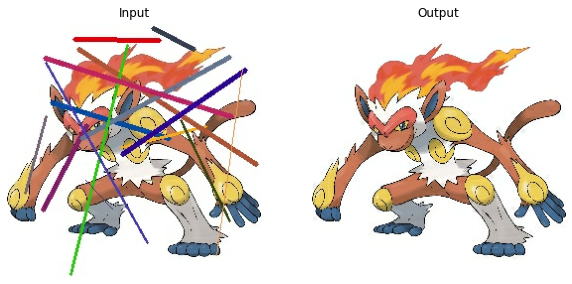

In [45]:
x = randrange(0,train_n)
display_list = [ ((load_image(randurls[x])[0] + 1)/2) , ((load_image(randurls[x])[1] + 1)/2)]
plt.figure(figsize=(10,10))
title = ['Input', 'Output']
for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i])
      plt.axis('off')

Input Pipeline

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [47]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  # Capa convolucional
  result.add(tf.keras.layers.Conv2D(filters,
                                    kernel_size = size,
                                    strides = 2,
                                    padding = 'same',
                                    kernel_initializer=initializer,                               
                                    use_bias=not apply_batchnorm))
                                    
  if apply_batchnorm:
    # Capa de BatchNorm
    result.add(tf.keras.layers.BatchNormalization())
    
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [48]:
def upsample(filters, size, apply_dropout=False):
  
  result = tf.keras.Sequential()
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  # Capa convolucional
  result.add(tf.keras.layers.Conv2DTranspose(filters,
                                             kernel_size = size,
                                             strides = 2,
                                             padding = 'same',
                                             kernel_initializer=initializer,                               
                                             use_bias=False))
  # Capa de BatchNorm
  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
    
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [49]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0., 0.02)
  
  last = tf.keras.layers.Conv2DTranspose(filters = 3,
                                         kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
  
  concat = tf.keras.layers.Concatenate()

  x = inputs
  
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  last = last(x)

  return tf.keras.Model(inputs=inputs, outputs=last)

generator = Generator()

Build the Discriminator

In [50]:
def Discriminator():
  
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512, 4)(down3) # (bs, 32, 32, 512)

  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = 'same')(down4) 
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

Define the loss functions and the optimizer

In [51]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [52]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [54]:
def generate_images(model, input, tar, file_name ,train_or_test, save_filename = False, display_imgs = True):

  prediction = model(input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + file_name + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(15,15))

  display_list = [input[0], tar[0], prediction[0]]

  if train_or_test == "train":
    title = ['Input Image Train', 'Image Truth Train', 'Predicted Image']
  if train_or_test == "test":
    title = ['Input Image Test', 'Image Truth Test', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow((display_list[i] + 1)/2)
      plt.axis('off')
        
  plt.show()
  time.sleep(3)

In [55]:
@tf.function
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = disc_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))


In [56]:
LAMBDA = 100 # Ver q es nuevo hiperparámetro lambda, p. ej. dando xx veces la
#importancia de la pérdida L1 que la pérdida adversaria para el generador durante el entrenamiento.

In [57]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    
    # Train
    for input_image, target in dataset:
      print('Epoch ' + str(epoch) + '/' + str(epochs) + '- train:' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
      clear_output(wait=True)
    
    imgi = 0
    for inp, tar in train_dataset.take(1):
      generate_images(generator, inp, tar, file_name = "train/" + str(imgi) + '_' + str(epoch), train_or_test= "train", save_filename=True, display_imgs=True)
      imgi += 1

    imgi = 0
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar, file_name = "test/" + str(imgi) + '_' + str(epoch), train_or_test= "test", save_filename=True, display_imgs=True)
      imgi += 1

In [58]:
os.mkdir(OUTPUT + "/train")
os.mkdir(OUTPUT + "/test")

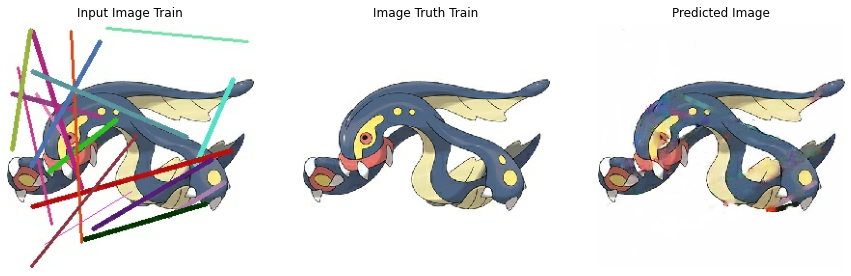

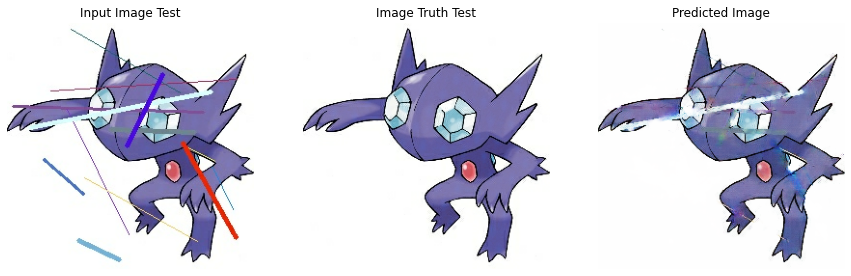

In [59]:
train(train_dataset, 200)

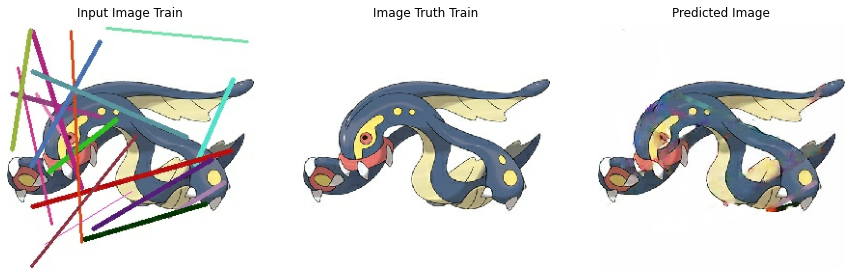

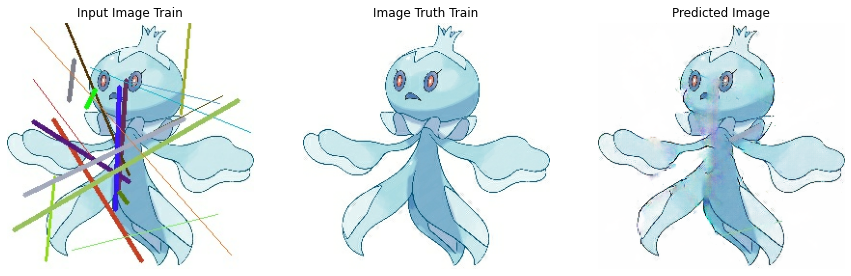

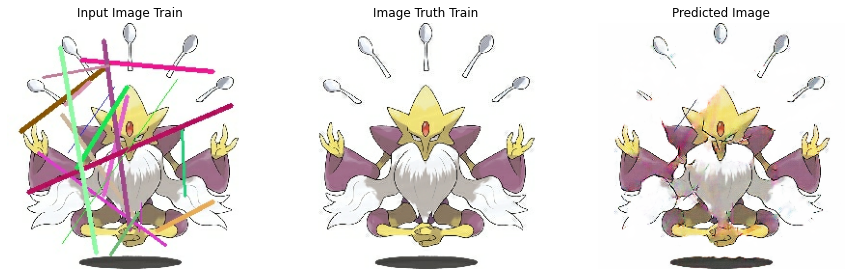

In [60]:
# Run the trained model on a few examples from the train dataset
for inp, tar in train_dataset.take(3):
  generate_images(generator, inp, tar, file_name = "None" , train_or_test = "train")

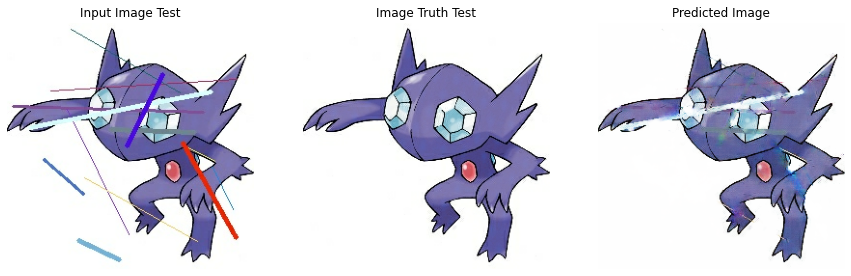

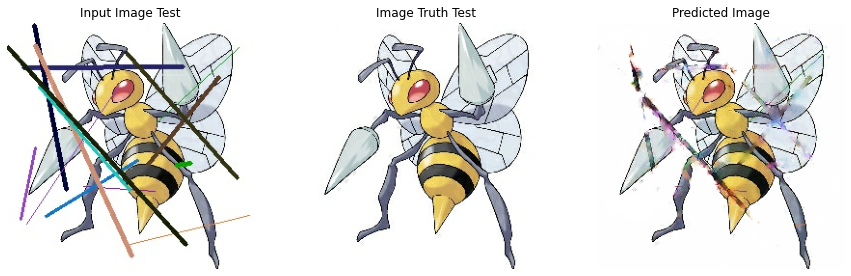

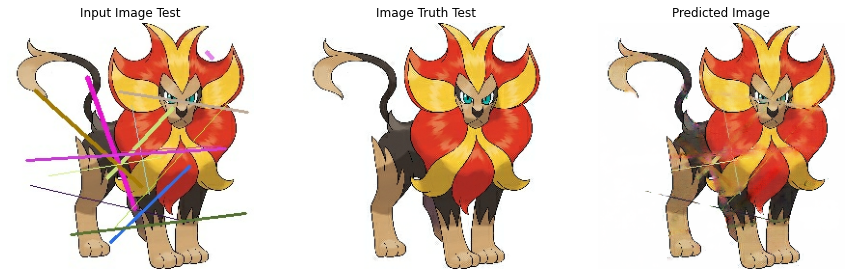

In [61]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(3):
  generate_images(generator, inp, tar, file_name = "None" , train_or_test = "test")

In [65]:
import imageio as io

search_dir = PATH + '/output/train'
os.chdir(search_dir)
filenames = filter(os.path.isfile, os.listdir(search_dir))
filenames = [os.path.join(search_dir, f) for f in filenames] # add path to each file
filenames.sort(key=lambda x: os.path.getmtime(x))

img_array = []
for filename in filenames:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter(PATH + '/train_pix2pix.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [66]:
search_dir = PATH + '/output/test'
os.chdir(search_dir)
filenames = filter(os.path.isfile, os.listdir(search_dir))
filenames = [os.path.join(search_dir, f) for f in filenames] # add path to each file
filenames.sort(key=lambda x: os.path.getmtime(x))

img_array = []
for filename in filenames:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter(PATH + '/test_pix2pix.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [67]:
from google.colab import files
files.download(PATH + '/train_pix2pix.avi') 
files.download(PATH + '/test_pix2pix.avi') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Subir ejemplo a mano

In [69]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, height, width):
  inimg = tf.image.resize(inimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return inimg

In [70]:
# Normalizar [-1, 1]
def normalize(inimg):
  inimg = (inimg / 127.5) - 1
  return inimg

In [71]:
def load_image(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(filename)),tf.float32)[...,:3]
  inimg = resize(inimg, IMG_HEIGHT, IMG_WIDTH)
  inimg = normalize(inimg)
  return inimg

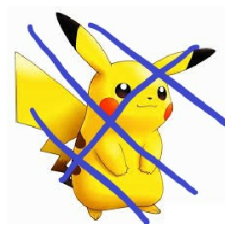

In [72]:
ruta_caso_manual = "/content/Pix2Pix_AXA/mano.jpg"

img = ((load_image(ruta_caso_manual))) 

plt.imshow((img+1)/2)
plt.axis('off')    
plt.show()

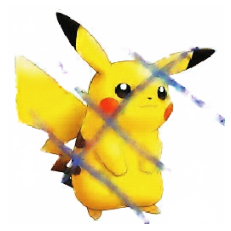

In [73]:
prediction = generator(tf.reshape(img,[1,256,256,3]), training=True)

plt.imshow((prediction[0]+1)/2)
plt.axis('off')    
plt.show()

In [ ]:
# Cargar modelo muy bueno

In [ ]:
#!unzip /content/Pix2Pix_AXA/modelo.zip -d /content/Pix2Pix_AXA/

In [ ]:
#generator_ok = tf.keras.models.load_model('/content/Pix2Pix_AXA/modelo',compile=False)

In [ ]:
#prediction = generator_ok(tf.reshape(img,[1,256,256,3]), training=True)

#plt.imshow((prediction[0]+1)/2)
#plt.axis('off')    
#plt.show()